In [ ]:
# Importing necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# loading the dataset
df = pd.read_csv('/content/train.csv')

In [ ]:
# Displaying the first few rows of the DataFrame
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
# Printing information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
# Retrieving the shape of the DataFrame
df.shape

(913000, 4)

In [ ]:
# Generating descriptive statistics of the DataFrame
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [ ]:
# Checking for missing values in the DataFrame
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
# Dropping columns 'store' and 'item' from the DataFrame
df = df.drop(['store', 'item'], axis = 1)

In [ ]:
# Processing the date column to aggregate monthly sales
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.to_period('M')
monthly_sales = df.groupby('date').sum().reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [ ]:
# Displaying the first few rows of the monthly_sales DataFrame
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


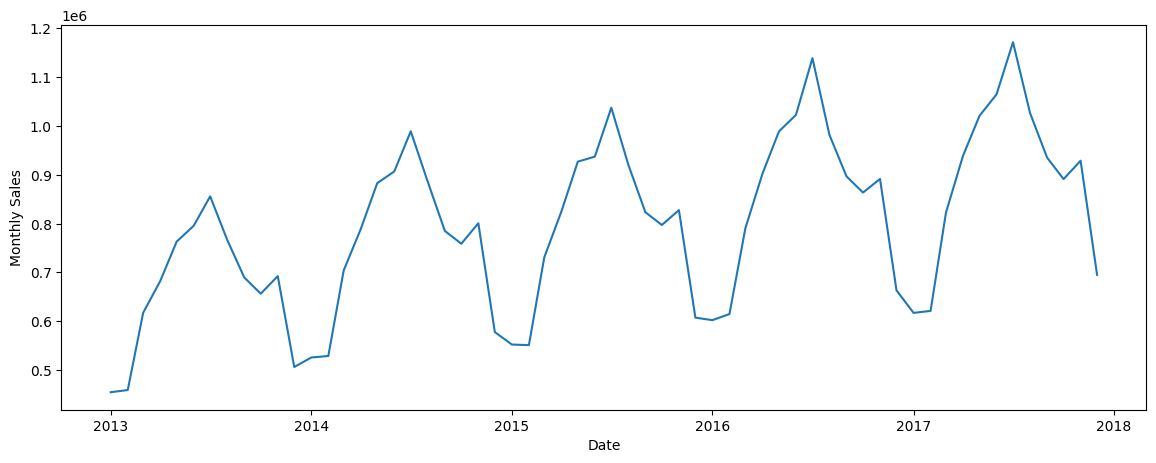

In [ ]:
# Plotting monthly sales data
plt.figure(figsize=(14, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.show()

In [ ]:
# Calculating the difference in monthly sales and displaying the first few rows
monthly_sales['sales_difference'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_difference
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


In [ ]:
# Printing information about the monthly_sales DataFrame
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 1 to 59
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              59 non-null     datetime64[ns]
 1   sales             59 non-null     int64         
 2   sales_difference  59 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.8 KB


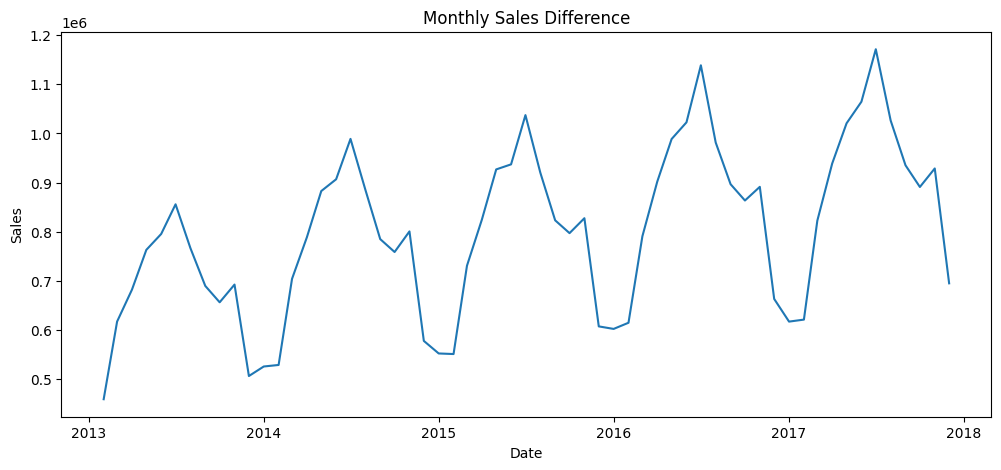

In [ ]:
# Plotting monthly sales data with differences
plt.figure(figsize=(12,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales Difference')
plt.show()

In [ ]:
# Creating a supervised learning dataset by dropping 'date' and 'sales' columns
supervised_data = monthly_sales.drop(['date','sales'],axis = 1)

In [ ]:
# Creating lagged features for monthly sales differences in supervised_data
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_difference'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(5)

,sales_difference,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


In [ ]:
# Splitting supervised_data into train and test sets
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
# Print the shape of the training data
print('Train Data Shape:', train_data.shape)
# Print the shape of the test data
print('Test Data Shape:', test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [ ]:
# Scaling train_data and test_data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
# Splitting train_data and test_data into input features and target variables
x_train,y_train = train_data[:,1:],train_data[:,0:1]
x_test,y_test = test_data[:,1:],test_data[:,0:1]
# Flatten y_train into a 1-dimensional array
y_train = y_train.ravel()
# Flatten y_test into a 1-dimensional array
y_test = y_test.ravel()
# Print the shape of x_train (input features for training)
print('x_train shape:',x_train.shape)
# Print the shape of y_train (input features for training)
print('y_train shape:',y_train.shape)
# Print the shape of y_test (input features for training)
print('y_test shape:',y_test.shape)
# Print the shape of x_test (input features for training)
print('x_test shape:',x_test.shape)

x_train shape: (35, 12)
y_train shape: (35,)
y_test shape: (12,)
x_test shape: (12, 12)


In [ ]:
# Creating predict_df DataFrame with the last 12 sales dates
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
# Extracting actual sales data from the last 13 months in monthly_sales
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [ ]:
# Fitting a Linear Regression model and making predictions
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre = lr_model.predict(x_test)

In [ ]:
# Transforming and inverse-transforming predictions using lr_model and scaler
lr_model = lr_pre.reshape(-1, 1)
lr_pre_test_set = np.concatenate([lr_model, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [ ]:
# Calculating predictions and merging with actual sales data in predict_df
result_list = []
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list,name='Linear Prediction')
predict_df = predict_df.merge(lr_pre_series,left_index =True, right_index = True)

In [ ]:
# Assuming predict_df was updated correctly with predictions
predict_df

,date,Linear Prediction
0,2017-01-01,6.479148e+05
1,2017-02-01,6.283374e+05
2,2017-03-01,8.195190e+05
3,2017-04-01,9.436391e+05
4,2017-05-01,1.033653e+06
5,2017-06-01,1.065286e+06
6,2017-07-01,1.201561e+06
7,2017-08-01,1.002123e+06
8,2017-09-01,9.415142e+05
9,2017-10-01,9.080646e+05


In [ ]:
# Calculating evaluation metrics for Linear Regression model predictions
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print('Linear Regression MSE:' , lr_mse)
print('Linear Regression MAE: ' , lr_mae )
print('Linear Regression R2:', lr_r2 )

Linear Regression MSE: 16221.272385416869
Linear Regression MAE:  12433.184266490736
Linear Regression R2: 0.9906152516380969


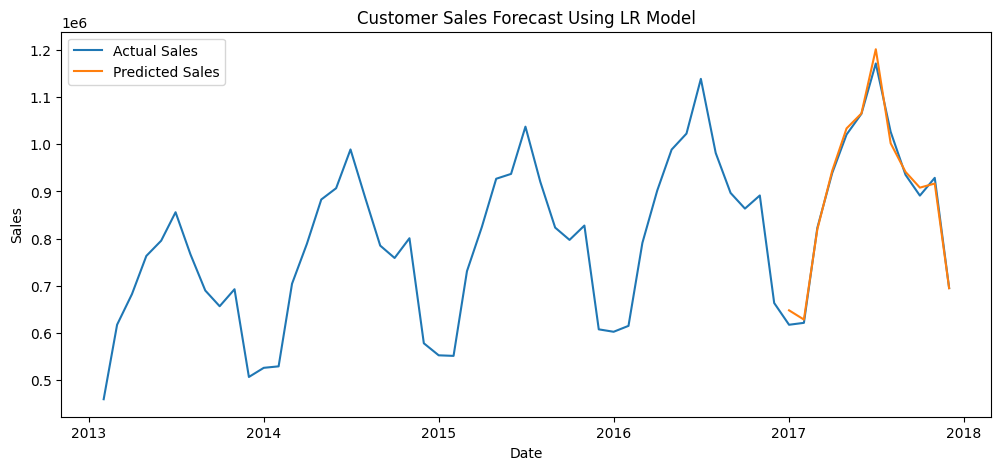

In [ ]:
# Plotting actual vs predicted sales using the Linear Regression model
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Predicted Sales')
plt.title('Customer Sales Forecast Using LR Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()